Для начала создадим класс псевдо-файла, который ведет себя аналогично файлу, но наодится в памяти, а значит работает быстрее и не нагружает жесткий диск

In [42]:
from contextlib import contextmanager
from pathlib import Path

pseudofiles={}

class PseudoFile:
    def __init__(self):
        self.d = []
        self.i=-1

    def write(self,data):
        self.d.append(data)
        
    def close(self):
        self.i=-1
    
    def readline(self):
        self.i+=1
        return self.d[self.i] if len(self.d)>self.i else ""

def pseudoopen(name,arg):
    global pseudofiles
    if arg=="rp":
        return pseudofiles[name.split(".")[0]]
    elif arg=="wp":
        pseudofiles[name.split(".")[0]]=PseudoFile()
        return pseudofiles[name.split(".")[0]]
   
       
def pseudoopen_meta(function):
    def wrapper(name,arg):        
        if arg in {"rp","wp"} :
             function=pseudoopen
        return function(name,arg)
    return wrapper

original_open = open

open = pseudoopen_meta(original_open)

@contextmanager
def open_files(*args):
    if args:
        files = {arg[0].split(".")[0]:open(arg[0],arg[1]) for arg in args}
        try:
            yield files
        finally:
            for f in files:
                files[f].close()

Код для генерации лога взят из предоставленного generate_logs.py, но он создает псевдофайлы и возвращает кол-во строк, чтобы удобнее было тестировать

In [74]:
import time
import dataclasses
import random
import json

from datetime import datetime, timedelta
_MAX_LOG_SIZE_BYTES = 2 ** 15  
_LOG_LEVELS = b'DEBUG', b'INFO', b'WARNING', b'ERROR'

_PERSON_NAME = 'Bender', 'Fry', 'Leela', 'Amy', 'Farnsworth', 'Dr. Zoidberg'
_ACTION = 'said', 'took', 'played', 'ate', 'saw', 'built', 'killed', 'created', 'brought', 'robbed'
_OBJECT = 'an apple', 'a car', 'a boat', 'a rocket', 'a mall', 'a fish', 'a bottle of bear', 'a man'
_PLACE = 'at park', 'on the Mars', 'near the Square Garden', 'in L.A.'
_WHEN = 'day before yesterday', 'yesterday', 'today', 'tomorrow', 'day after tomorrow'

@dataclasses.dataclass
class LogRecord:
    log_level: str
    timestamp: str
    message: str
        
_RECORD_TEMPLATE = LogRecord(
    log_level='<LOG_LEVEL>',
    timestamp='<TIMESTAMP>',
    message='<MESSAGE>',
)

_MESSAGE_TEMPLATE = json.dumps(dataclasses.asdict(_RECORD_TEMPLATE)).encode('utf-8')
_MESSAGE_TEMPLATE += b'\n'

        
def generate_logfile(fname,start_time=datetime.now()):
    person_name, action = _PERSON_NAME, _ACTION
    object, place, when = _OBJECT, _PLACE, _WHEN
    log_levels, message_template = _LOG_LEVELS, _MESSAGE_TEMPLATE
    rand, td, ln = random.random, timedelta, len
    with open_files((fname,"wp")) as fp:
        current_time = start_time
        total_size, max_size, total_lines = 0, _MAX_LOG_SIZE_BYTES,0
        correct_order=[]
        while total_size < max_size:
            timestamp = f"{current_time.year}-{current_time.month:02}-{current_time.day:02} " \
                        f"{current_time.hour}:{current_time.minute:02}:{current_time.second:02}".encode('utf-8')

            message = f"{person_name[int(6 * rand())]} " \
                      f"{action[int(10 * rand())]} " \
                      f"{object[int(8 * rand())]} " \
                      f"{place[int(4 * rand())]} " \
                      f"{when[int(5 * rand())]}".encode('utf-8')

            data = message_template \
                .replace(b'<LOG_LEVEL>', log_levels[int(4 * rand())]) \
                .replace(b'<TIMESTAMP>', timestamp) \
                .replace(b'<MESSAGE>', message)
                      
            fp[fname.split(".")[0]].write(data)
            total_lines+=1
            total_size += ln(data)
            current_time += td(seconds=int(10 * rand()))

       
    return total_lines



Четыре алгоритма: первый выполняет десериализацию с помощь json, второй через поиск подстроки 'amp": "'(разумеется, этот алгоритм не будет корректно работать, если формат входных логов изменить так, что подстрока найдется в другом месте). Третий преобразовывает подстроку в datetime, т.к., возможно, сравнение и поиск минимума будет быстрее в таком формате. Четвертый - оптимизированный для большего кол-ва входных файлов, в нем долгие операции вынесенны за пределы цикла 

In [90]:
def merge_logs_json(output,*args):
    args = [(arg,"rp") for arg in args]
    with open_files((output,"wp"),*args) as files:
        output_name=output.split(".")[0]
        current_lines={}
        for fname in set(files.keys()):
            current_lines[fname]=files[fname].readline() 
            if not current_lines[fname]:
                current_lines.pop(fname)

        while current_lines.keys():
            timestamps={key:json.loads(value)["timestamp"] for key,value in current_lines.items()}
            min_fname = min(timestamps, key=timestamps.get)
            files[output_name].write(current_lines[min_fname])
            current_lines[min_fname] = files[min_fname].readline()
            if not current_lines[min_fname]:
                current_lines.pop(min_fname)

def merge_logs_substring(output,*args):
    args = [(arg,"rp") for arg in args]
    with open_files((output,"wp"),*args) as files:
        output_name=output.split(".")[0]
        current_lines={}
        for fname in set(files.keys()):
            current_lines[fname]=files[fname].readline() 
            if not current_lines[fname]:
                current_lines.pop(fname)       
        while current_lines.keys():
            timestamps={key:value.split(b'amp": "')[1].split(b'",')[0] for key,value in current_lines.items()}
            min_fname = min(timestamps, key=timestamps.get)
            files[output_name].write(current_lines[min_fname])
            current_lines[min_fname] = files[min_fname].readline()
            if not current_lines[min_fname]:
                current_lines.pop(min_fname)
                
def merge_logs_datetime(output,*args):
    args = [(arg,"rp") for arg in args]
    with open_files((output,"wp"),*args) as files:
        output_name=output.split(".")[0]
        current_lines={}
        for fname in set(files.keys()):
            current_lines[fname]=files[fname].readline() 
            if not current_lines[fname]:
                current_lines.pop(fname)       
        while current_lines.keys():
            timestamps={key:datetime.strptime((value.split(b'amp": "')[1].split(b'",')[0]).decode(), "%Y-%m-%d %H:%M:%S") for key,value in current_lines.items()}
            min_fname = min(timestamps, key=timestamps.get)
            files[output_name].write(current_lines[min_fname])
            current_lines[min_fname] = files[min_fname].readline()
            if not current_lines[min_fname]:
                current_lines.pop(min_fname)
        
def merge_logs_optimized(output,*args):
    args = [(arg,"rp") for arg in args] 
    with open_files((output,"wp"),*args) as files:
        output_name=output.split(".")[0]
        current_lines={}
        for fname in set(files.keys())-{output_name}:
            current_lines[fname]=files[fname].readline() 
            if not current_lines[fname]:   
                current_lines.pop(fname)   
        timestamps={key:value.split(b'amp": "')[1].split(b'",')[0] for key,value in sorted(current_lines.items(), key=lambda item: item[1])}      
        while current_lines.keys():          
            f_min=list(timestamps.keys())[0]
            files[output_name].write(current_lines[f_min])    
            current_lines[f_min] = files[f_min].readline() 
            if not current_lines[f_min]:                     
                current_lines.pop(f_min)                      
                timestamps.pop(f_min)
            else:
                timestamps[f_min] = current_lines[f_min].split(b'amp": "')[1].split(b'",')[0]  
                timestamps={key:value for key,value in sorted(timestamps.items(), key=lambda item: item[1])}  
                
                

Тесты: test_order проверяет порядок строк и чтобы кол-во строк совпадало, test записывает в мвссив средние для 10ти выборок результаты по времени

In [91]:
MAX_TESTS_NUM = 10
MAX_FILES_NUM = 5
import numpy as np

def test_order(fname,expected_numder_of_lines):
    with open_files(("{}.jsonl".format(fname),"rp")) as files:
        line = files[fname].readline()
        counter=0
        if(line):
            timestamp=json.loads(line)["timestamp"]
            counter+=1
        while line:
            line = files[fname].readline()
            counter+=1
            if line and json.loads(line)["timestamp"]<timestamp:
                print("FAIL: line number {} timestamp={} is less than line number {} timestamp={}".format(counter,
                                                                                                          json.loads(line)["timestamp"],
                                                                                                          counter-1,
                                                                                                          timestamp))
                return False
    if counter==expected_numder_of_lines+1:
        print("TEST OK, number of lines={}".format(counter-1))
        return True
    else:
        print("FAIL: got {} lines while expected number is {}".format(counter, expected_numder_of_lines))
        return False

def test(*funcs):
    global pseudofiles
    pseudofiles={}
    res=np.zeros((len(funcs),MAX_FILES_NUM-1,MAX_TESTS_NUM))
    expected_lines=[0]
    files_pool={"log_{}.jsonl".format(n):generate_logfile("log_{}.jsonl".format(n)) for n in range(MAX_FILES_NUM)}
    print("Files generated: = ",files_pool)
    
    for files_num in range(2,MAX_FILES_NUM+1):
        for testnum in range(MAX_TESTS_NUM):
            files_for_test=random.sample(list(files_pool.keys()),files_num)
            print("Files for test=",files_for_test)
            for funcnum,func in enumerate(funcs):
                t0 = time.time()
                func("output.jsonl",*files_for_test)
                res[funcnum,files_num-2,testnum] = time.time() - t0
                test_order("output",sum([files_pool[n] for n in files_for_test]))
    return res

In [93]:
res=test(merge_logs_json,merge_logs_substring,merge_logs_datetime,merge_logs_optimized)

Files generated: =  {'log_0.jsonl': 270, 'log_1.jsonl': 270, 'log_2.jsonl': 270, 'log_3.jsonl': 271, 'log_4.jsonl': 271}
Files for test= ['log_2.jsonl', 'log_1.jsonl']
TEST OK, number of lines=540
TEST OK, number of lines=540
TEST OK, number of lines=540
TEST OK, number of lines=540
Files for test= ['log_3.jsonl', 'log_0.jsonl']
TEST OK, number of lines=541
TEST OK, number of lines=541
TEST OK, number of lines=541
TEST OK, number of lines=541
Files for test= ['log_2.jsonl', 'log_1.jsonl']
TEST OK, number of lines=540
TEST OK, number of lines=540
TEST OK, number of lines=540
TEST OK, number of lines=540
Files for test= ['log_3.jsonl', 'log_1.jsonl']
TEST OK, number of lines=541
TEST OK, number of lines=541
TEST OK, number of lines=541
TEST OK, number of lines=541
Files for test= ['log_1.jsonl', 'log_3.jsonl']
TEST OK, number of lines=541
TEST OK, number of lines=541
TEST OK, number of lines=541
TEST OK, number of lines=541
Files for test= ['log_1.jsonl', 'log_3.jsonl']
TEST OK, number o

Построим результаты на графике. Substring работает быстрее для двух файлов, для большего кол-ва лучше optimized

Text(0, 0.5, 'Average time')

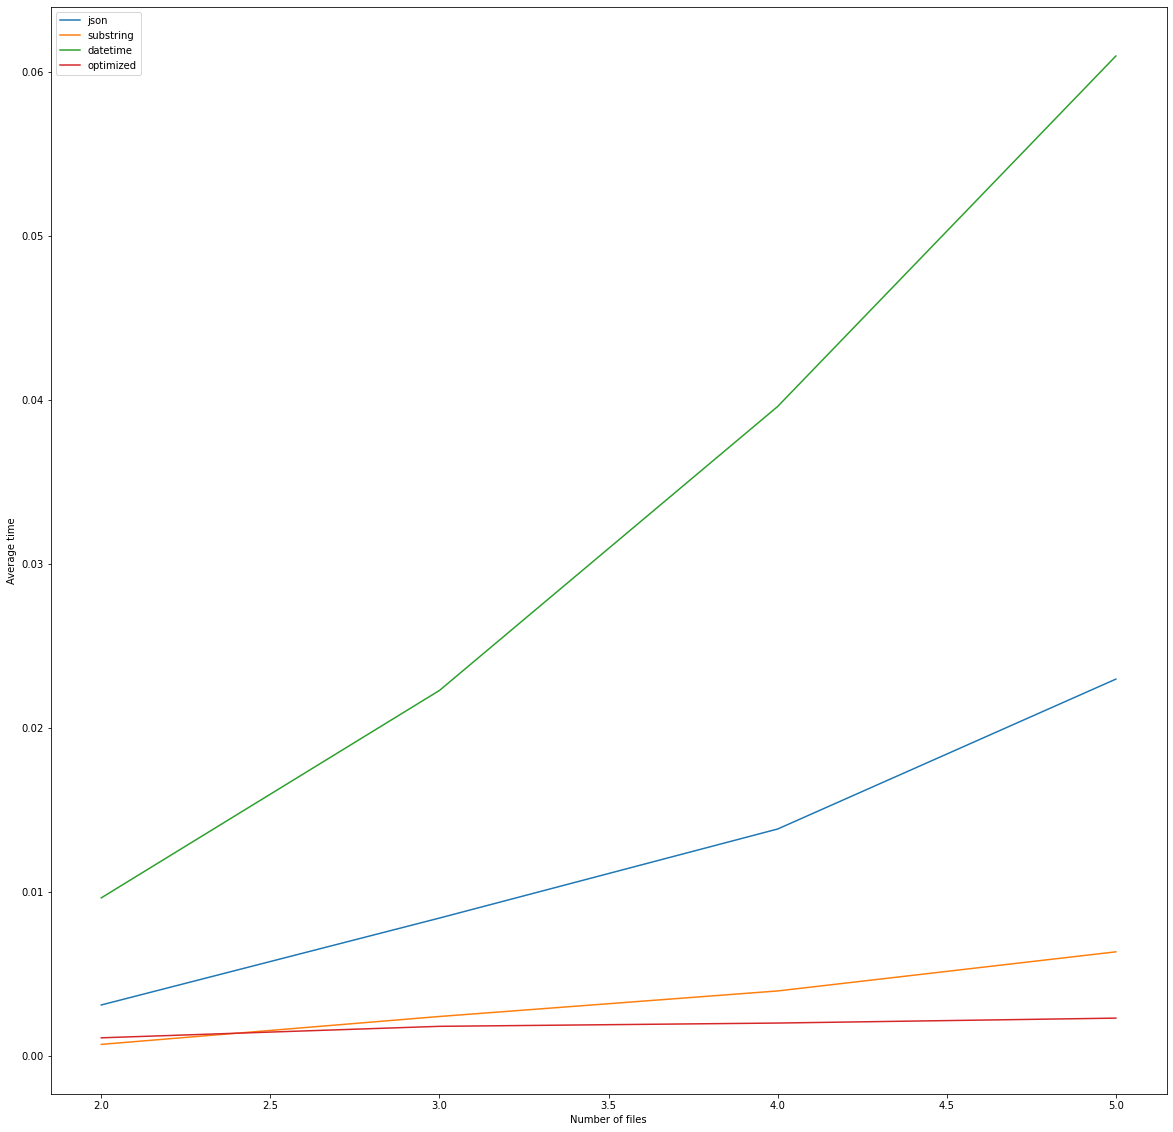

In [98]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))
for funcind,funcname in enumerate(["json","substring","datetime","optimized"]):
    plt.plot(np.arange(2,MAX_FILES_NUM+1),[np.mean(res[funcind][i]) for i in range(MAX_FILES_NUM-1)],label=funcname)
plt.legend()
plt.xlabel("Number of files")
plt.ylabel("Average time")